In [20]:
import xgboost as xgb
import pandas as pd
import src.train_utils as T
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')  # Try 'ggplot' as an alternative

# 1) show every column
pd.set_option('display.max_columns', None)

# 2) disable automatic expansion/wrapping
pd.set_option('display.expand_frame_repr', False)

# 3) bump the console width way up (or to None for ‘no limit’)
pd.set_option('display.width', None)

In [2]:
ds = xr.open_dataset('../datasets/exp_1_ds.nc')
mask = ds.time.dt.year < 2022
ds_excl_2022 = ds.sel(time=mask)
for t in range(1, 7+1):
    ds_excl_2022[f'delta_pm25_t-{t}'] = ds_excl_2022['delta_pm25_t'].shift(time=t)

for t in range(2, 11+1):
    ds_excl_2022[f'delta_pm25_ma{t}'] = ds_excl_2022['delta_pm25_t'].rolling(time=t, center=False, min_periods=1).mean()
    
ds_excl_2022 = ds_excl_2022.dropna(dim="time", how="any")
train_df = ds_excl_2022.to_dataframe().reset_index()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
base = ['delta_pm25_t', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']


params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}

feature_experiments = [('base', base)] + [
    (
        " + ".join(f"ma{j}" for j in range(3, t+1, 2)),
        base + [f"delta_pm25_ma{j}" for j in range(3, t+1, 2)]
    )
    for t in range(3, 11+1, 2)
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/6 [00:00<?, ?it/s]

Running experiment: base


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: ma3


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: ma3 + ma5


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: ma3 + ma5 + ma7


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: ma3 + ma5 + ma7 + ma9


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: ma3 + ma5 + ma7 + ma9 + ma11


  0%|          | 0/10 [00:00<?, ?it/s]

                     experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
0                          base          11   4.361622  2.964671     1.675788     4.937968     5.101307     8.723355    13.218467     2.039777     0.916728     1.001423     1.863846      4.137558
3               ma3 + ma5 + ma7          14   4.371268  2.977423     1.662767     5.008796     5.023354     8.617089    13.529491     2.064190     0.910839     0.977295     1.854592      4.064268
1                           ma3          12   4.373499  2.964785     1.637634     5.130383     5.107080     8.651720    13.390641     2.043499     0.908833     0.996614     1.840881      4.027705
4         ma3 + ma5 + ma7 + ma9          15   4.376895  2.987277     1.654541     4.957548     5.020148     8.617474    13.710630     2.063943     0.913637     0.973591     1.859605      3.997827
2                   

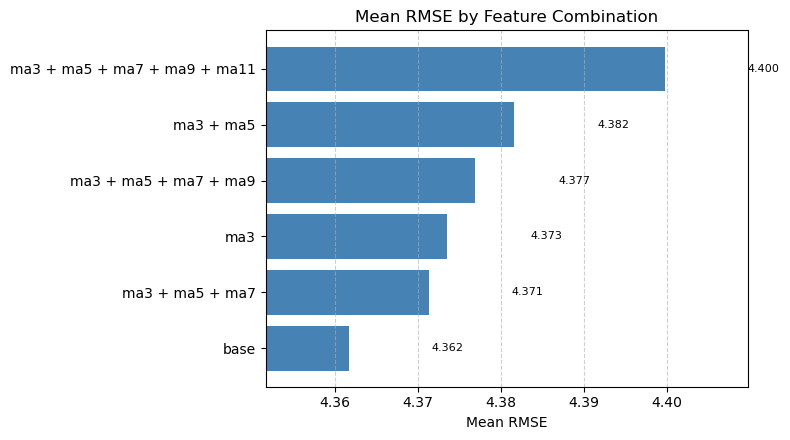

In [12]:
results = results.sort_values("mean_rmse")

plt.figure(figsize=(8, 4.5))
bars = plt.barh(results["experiment"], results["mean_rmse"], color="steelblue")
plt.xlabel("Mean RMSE")
plt.title("Mean RMSE by Feature Combination")
plt.xlim(results["mean_rmse"].min() - 0.01, results["mean_rmse"].max() + 0.01)

# Annotate bars
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.3f}", va='center', fontsize=8)

plt.tight_layout()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

In [13]:
base = ['delta_pm25_t', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']


params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}

feature_experiments = [('base', base)] + [
    (
        " + ".join(f"lag{j}" for j in range(1, t+1)),
        base + [f"delta_pm25_t-{j}" for j in range(1, t+1)]
    )
    for t in range(1, 7+1)
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/8 [00:00<?, ?it/s]

Running experiment: base


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: lag1


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: lag1 + lag2


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: lag1 + lag2 + lag3


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: lag1 + lag2 + lag3 + lag4


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: lag1 + lag2 + lag3 + lag4 + lag5


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: lag1 + lag2 + lag3 + lag4 + lag5 + lag6


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: lag1 + lag2 + lag3 + lag4 + lag5 + lag6 + lag7


  0%|          | 0/10 [00:00<?, ?it/s]

                                       experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
3                              lag1 + lag2 + lag3          14   4.335222  2.944554     1.669317     4.896278     5.106175     8.558902    13.263525     2.044481     0.912428     0.991419     1.855379      4.054319
7  lag1 + lag2 + lag3 + lag4 + lag5 + lag6 + lag7          18   4.344238  2.946910     1.660808     4.880879     5.072371     8.562890    13.433849     2.034336     0.915170     0.992495     1.851829      4.037750
5                lag1 + lag2 + lag3 + lag4 + lag5          16   4.350822  2.953381     1.663040     4.963037     5.090408     8.587520    13.360240     2.040799     0.914904     0.991675     1.851194      4.045402
6         lag1 + lag2 + lag3 + lag4 + lag5 + lag6          17   4.355659  2.956720     1.664781     4.952011     5.098478     8.585516    13.395

In [33]:
table = results[["experiment", "mean_rmse", "mean_mae"]]
print(table)

                                       experiment  mean_rmse  mean_mae
3                              lag1 + lag2 + lag3   4.335222  2.944554
7  lag1 + lag2 + lag3 + lag4 + lag5 + lag6 + lag7   4.344238  2.946910
5                lag1 + lag2 + lag3 + lag4 + lag5   4.350822  2.953381
6         lag1 + lag2 + lag3 + lag4 + lag5 + lag6   4.355659  2.956720
2                                     lag1 + lag2   4.358456  2.958128
1                                            lag1   4.359108  2.962054
0                                            base   4.361622  2.964671
4                       lag1 + lag2 + lag3 + lag4   4.366669  2.957759


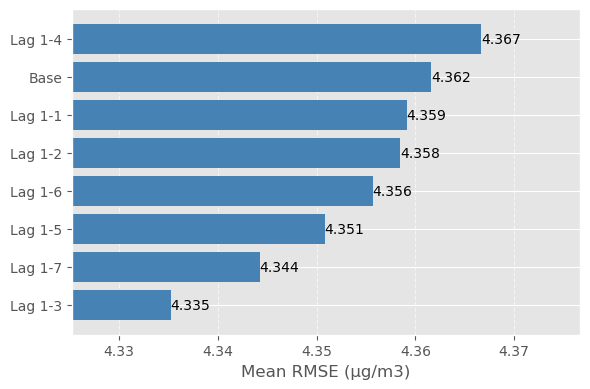

In [28]:
results = results.sort_values("mean_rmse")

names = []
for experiment in results["experiment"]:
    if experiment != "base":
        last = experiment[-1]
        names.append(f"Lag 1-{last}")
    else:
        names.append(f"Base")

plt.figure(figsize=(6, 4))
bars = plt.barh(names, results["mean_rmse"], color="steelblue")
plt.xlabel("Mean RMSE (μg/m3)")
plt.xlim(results["mean_rmse"].min() - 0.01, results["mean_rmse"].max() + 0.01)

# Annotate bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.3f}", va='center', fontsize=10)

plt.tight_layout()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

In [5]:

ds[f'delta_pm25_t-1'] = ds['delta_pm25_t'].shift(time=1)
ds[f'delta_pm25_t-2'] = ds['delta_pm25_t'].shift(time=2)
ds[f'delta_pm25_t-3'] = ds['delta_pm25_t'].shift(time=3)

ds = ds.dropna(dim="time", how="any")

ds.to_netcdf(
    "exp_2_ds.nc",
    format="NETCDF4",       # HDF5-backed NetCDF
    engine="netcdf4",      # or "netcdf4" if you have that
    encoding={
        var: {
            "zlib": True,
            "complevel": 4,
        }
        for var in ds.data_vars
    }
)